In [1]:
%matplotlib notebook
import numpy as np
import glob
from glob import glob
from astropy.io import ascii
from numpy import *
import yt
from yt.units import kpc
from scipy import interpolate

In [2]:
def running(DD, mass, half_window = 10):
    percs = []
    for d in DD:
        gd = where(abs(DD - d) < half_window)[0]

        percs.append(np.percentile(mass[gd], [16, 50, 84]))
    return np.array(percs)

In [3]:
halos = ['8508',
         '2878',
         '2392',
         '5016',
         '5036',
         '4123']

In [4]:
sat_cat = ascii.read('/Users/rsimons/Desktop/foggie/catalogs/satellite_properties.cat')
combine_all = np.load('/Users/rsimons/Desktop/foggie/catalogs/sat_track_locations/combine_all.npy', allow_pickle = True)[()]


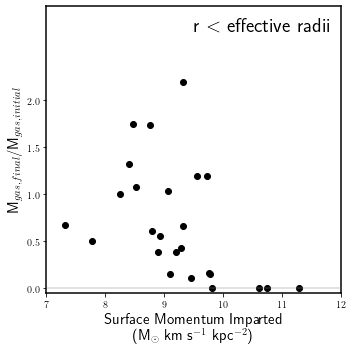

In [11]:
#fig, axes = plt.subplots(6, 6, figsize = (30, 30))
fig2, axes2 = plt.subplots(1, 1, figsize = (5, 5))
cnt = 0
for h, halo in enumerate(halos):
    sat_cat_halo = sat_cat[sat_cat['halo'] == int(halo)]
    for sat in sat_cat_halo['id']:
        if sat == '0': continue
        tracks = combine_all[halo][sat]
        min_DD = combine_all[halo][sat]['min_DD']
        max_DD = combine_all[halo][sat]['max_DD']
        enter_DD = combine_all[halo][sat]['enter_DD']

        ram_all = []
        time_all = []
        if tracks['max_time'].value -  tracks['enter_time'].value < 0.05: continue
        for DD in np.arange(enter_DD, max_DD):
            try: track = tracks[DD]
            except: continue
            v = yt.YTArray(np.sqrt(track['vx']**2. + \
                                   track['vy']**2. + \
                                   track['vz']**2.), 'km/s')
            
            dx = v * yt.YTArray(5, 'Myr')
            start_ray = 2.
            gd = where((track['ray_dist'] > start_ray) & (track['ray_dist'] < start_ray + dx.to('kpc').value))[0]  

            vel_ram = track['ray_vel'][gd]
            den_ram = track['ray_den'][gd]
            vel_ram[vel_ram > 0] = 0.
            ram_all.append(mean(vel_ram)**2. * mean(den_ram))            
            time_all.append(track['time'].value - tracks['enter_time'].value)
        if not np.isnan(time_all[0]):
            ram_all = yt.YTArray(ram_all).to('dyne*cm**-2')
            #axes.ravel()[cnt].plot(time_all, ram_all, color = 'black', linewidth = 1)
            interp = interpolate.interp1d(time_all, ram_all)
            dt = 1.e-4
            time_interp = np.arange(min(time_all), max(time_all), dt)
            ram_interp = interp(time_interp)
            #axes.ravel()[cnt].plot(time_interp, ram_interp, color = 'blue', linewidth = 1, linestyle = '--')
            cnt+=1
            gas_type = ''
            tot_mom = sum(yt.YTArray(ram_interp, 'dyne*cm**-2') * yt.YTArray(dt, 'Gyr')).to('Msun*km/s/kpc**2')
            
            meas_mass_dist = 1.
            gd = where(tracks[enter_DD]['mass_dist'] < meas_mass_dist)
            tot_mass = tracks[enter_DD]['gas_mass'][gd] + tracks[enter_DD]['stars_mass'][gd]# + tracks[enter_DD]['dm_mass'][gd]
            argre = argmin(abs(tot_mass -  tot_mass[-1]/2.))
            re = tracks[enter_DD]['mass_dist'][gd][argre]            
            min_r = 0.
            max_r = re            
            parts = where((tracks[enter_DD]['%smass_dist'%gas_type] > min_r) & (tracks[enter_DD]['cold_mass_dist'] < max_r))
            
            mass_stars_init =  tracks[enter_DD]['stars_mass'][parts][-1]
            mass_stars_final =  tracks[max_DD]['stars_mass'][parts][-1]
            delta_stars = mass_stars_final - mass_stars_init
            mass_init = tracks[enter_DD]['%sgas_mass'%gas_type][parts][-1]
            mass_final = tracks[max_DD]['%sgas_mass'%gas_type][parts][-1]# + delta_stars            
            mass_newstars = max((mass_stars_final - mass_stars_init,0))
            
            if tot_mass[-1] < 1.e11: color = 'black'
            else: color = 'grey'

            axes2.plot(np.log10(tot_mom), mass_final/mass_init, 'o', color = color)
            

axes2.axhline(y = 0.0, color = 'grey', alpha = 0.3, zorder = 10)
axes2.set_yticks(np.arange(0, 2.5, 0.5))
axes2.set_ylim(-0.05, 3.)
axes2.set_xlim(7, 12)

axes2.annotate(r'r $<$ effective radii', (0.97, 0.96), \
                xycoords = 'axes fraction', ha = 'right', va = 'top', color = 'black', fontsize = 20)
            
'''
for ax in axes.ravel(): 
    ax.set_ylim(0, 1.e-8)
    ax.set_yscale('symlog', linthreshy = 1.e-17)
    ax.set_yticks(concatenate((np.array([0]), 10.**np.arange(-17, -7, 2))))
'''
fig_dir = '/Users/rsimons/Dropbox/foggie/figures/for_paper'

axes2.set_xlabel('Surface Momentum Imparted\n(M$_{\odot}$ km s$^{-1}$ kpc$^{-2}$)')
axes2.set_ylabel(r'M$_{gas, final}$/M$_{gas, initial}$')

fig2.tight_layout()
#fig.savefig(fig_dir + '/big_plot.png', dpi = 200)
fig2.savefig(fig_dir + '/momentum_vs_coldgaslost.png', dpi = 200)



In [31]:
tot_mom

7395333119.461614 Msun*km/(kpc**2*s)

In [16]:
 np.arange(0.0, 1.0, 1.e-3)


array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
       0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
       0.126, 0.127,

In [84]:
tracks

{355: {'number_stars': 1000,
  'x_init': 17182.118,
  'y_init': 17022.668,
  'z_init': 17157.616,
  'x': 17182.178,
  'y': 17022.663,
  'z': 17157.581,
  'vx': -39.171,
  'vy': -198.841,
  'vz': -44.674,
  'ray_den': YTArray([2.71177425e-26, 0.00000000e+00, 2.97264624e-22, 0.00000000e+00,
           1.84479528e-26, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           1.16856859e-23, 8.40110861e-26, 8.22329864e-27, 0.00000000e+00,
           3.20341482e-26, 2.71571956e-26, 4.97228483e-24, 9.30294253e-27,
           4.23921983e-26, 2.18809156e-24, 2.20314818e-26, 5.00814572e-25,
           9.34083402e-23, 2.84775048e-24, 1.59378552e-22, 3.79541504e-23,
           2.23376881e-23, 1.08588426e-24, 2.62090408e-26, 1.32394318e-23,
           6.94456546e-23, 4.90728279e-24, 4.81441064e-24, 5.00817010e-23,
           9.04975836e-24, 4.87710891e-23, 4.05668436e-23, 2.29929552e-23,
           2.40429915e-23, 2.04068778e-23, 5.06352148e-23, 2.98326854e-23,
           4.29595105e-23, 4.275647

In [46]:
yt.YTArray(ram_all).to('dyne*cm**-2')

YTArray([7.96611078e-10, 0.00000000e+00, 2.34780838e-13, 3.30927815e-12,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.72267064e-14, 2.22500183e-12,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.98516897e-13, 0.00000000e+00, 1.73565013e-11, 1.42115701e-11,
         8.94846672e-10, 0.00000000e+00, 1.96500329e-14, 1.76511232e-15,
         0.00000000e+00, 4.50183986e-12, 4.92000602e-11, 0.00000000e+00,
         2.69811964e-11, 1.39236298e-10, 2.44305205e-09, 1.26550421e-11,
         3.97677330e-10, 5.37043099e-17, 7.69364100e-11, 2.18117115e-13,
         1.77422808e-11, 1.94580507e-12, 0.00000000e+00, 2.07418869e-13,
         5.21640238e-12, 0.00000000e+00, 1.88878031e-12, 8.14507115e-11,
         2.17801306e-12, 1.40417763e-12, 1.27084020e-11, 4.59197637e-11,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27550866e-09,
         1.80777989e-12, 1.51306875e-12, 2.34504525

In [42]:
mass_init

463534729.18911403 Msun